<a href="https://colab.research.google.com/github/Marco-Sau/Time-Series-Analysis/blob/master/Laboratorio_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelli di apprendimento per rinforzo basato sulle politiche

Nei metodi basati sulle politiche, impariamo direttamente ad approssimare π* senza dover imparare una funzione stato-valore o azione-valore. L'idea è quella di parametrizzare la politica. Ad esempio, utilizzando una rete neurale π_θ, questa politica produrrà una distribuzione di probabilità sulle azioni (politica stocastica). Il nostro obiettivo è quindi quello di massimizzare le prestazioni della politica parametrizzata utilizzando l'ottimizzazione basata sulla discesa stocastica del gradiente. Per farlo, controlliamo il parametro π_θ che influenzerà la distribuzione delle azioni dato uno stato. Nei metodi basati sulle politiche, l'ottimizzazione è per la maggior parte del tempo on-policy, poiché per ogni aggiornamento si utilizzano solo i dati (traiettorie) raccolti dalla versione più recente di π_θ.

Nello specifico, alla fine di questo notebook, sarete in grado di:
- [Creare un agente](##Creare-un-agente): l'entità che andrà a prendere le decisioni sulle azioni da compiere nell'ambiente
- [Creare le policy](##Creare-le-policy): instanziare l'insieme di regole (stavolta parametriche) che l'agente segue per prendere le sue decisioni.
- [Definire le metriche e la valutazione](##Definire-le-metriche-e-la-valutazione) necessarie per il processo di addestramento.
- [Addestrare un agente](##Addestrare-un-agente): l'obiettivo è massimizzare la ricompensa totale attesa (non minimizzare un punteggio di perdita).

![](https://gymnasium.farama.org/_images/cart_pole.gif)

## Installazione e import librerie

In [ ]:
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet xvfbwrapper

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:4 http://archive.ubuntu.com/ubuntu focal InRelease
Get:5 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Fetched 336 kB in 2s (201 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
freeglut3-dev is already the newest version 

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
import tf_agents
import tensorflow as tf
import PIL.Image
import pyvirtualdisplay
import numpy as np
import reverb
import matplotlib.pyplot as plt
import IPython
import base64
import imageio
import gym

## Configurazione dell'ambiente
Impostiamo i parametri che regoleranno l'allenamento nella "palestra" per la base del palo.

In [ ]:
# Per poter renderizzare lo stato del nostro ambiente, è necessario creare uno "schermo virtuale".
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

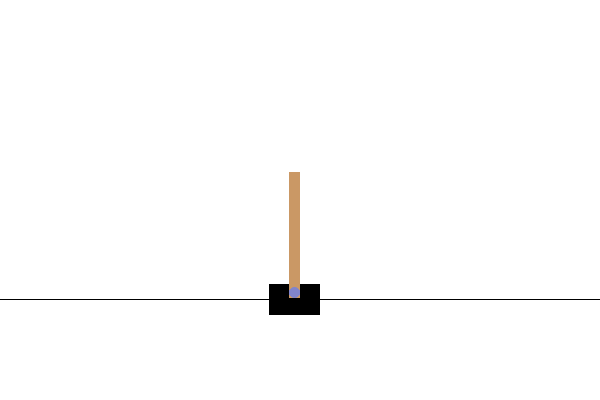

In [ ]:
# Carichiamo l'ambiente
env_name = 'CartPole-v0'
env = tf_agents.environments.suite_gym.load(env_name)

# Resettiamo l'ambiente ad uno stato neutro
env.reset()

# Renderizziamo l'immagine attuale del nostro ambiente
PIL.Image.fromarray(env.render())

Il metodo `environment.step(action)` esegue un'azione nell'ambiente e rende un TimeStep (una tupla) contenente l'osservazione successiva e la ricompensa per l'azione eseguita.

In [ ]:
spec = env.time_step_spec()
print("Specifica di un'osservazione dello stato dell'ambiente")
print(spec.observation)
print("\nSpecifica di una ricompensa per l'esecuzione di un'azione")
print(spec.reward)
print('\nSpecifica di una generica azione effettuabile:')
print(env.action_spec())

Specifica di un'osservazione dello stato dell'ambiente
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])

Specifica di una ricompensa per l'esecuzione di un'azione
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

Specifica di una generica azione effettuabile:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


Esaminiamo più nel dettaglio ciò che abbiamo appena visto.
- Un'osservazione (ovvero lo stato interno del nostro ambiente) è composto, per questo task, da 4 numeri float:
  - Posizione della base del palo
  - Velocità della base del palo
  - Angolazione del palo
  - Velocità angolare del palo
- Una ricompensa (reward) è un singolo scalare in virgola mobile che indica quanto l'azione eseguita sia corretta
- Un'azione è uno scalare intero che può assumere solo due valori;
  - 0 -> muoviti a sinistra
  - 1 -> muoviti a destra

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.03521048, -0.02673343, -0.03593938, -0.00220052], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Prossimo time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.03467581,  0.16888502, -0.03598339, -0.30600262], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


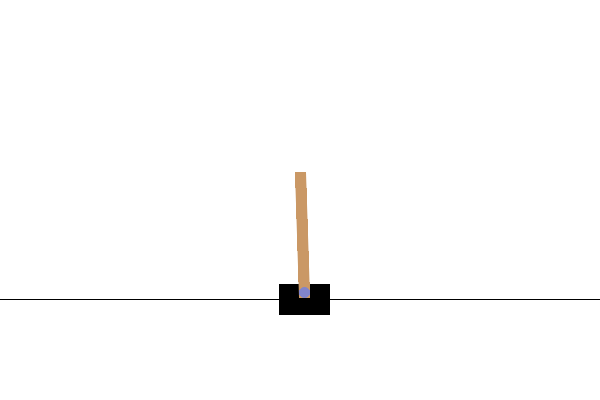

In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

# Instanziamo un'azione (in questo caso un movimento verso destra)
action = np.array(1, dtype=np.int32)

# Eseguiamo l'azione
next_time_step = env.step(action)
# E visualizziamo lo stato dell'ambiente dopo l'esecuzione della stessa
print('Prossimo time step:')
print(next_time_step)
PIL.Image.fromarray(env.render())

Per questa tipologia di problemi, vengono instanziati due ambienti: uno per l'addestramento e l'altro per la valutazione. L'ambiente Cartpole, come la maggior parte degli ambienti, è scritto in Python puro. Per renderlo compatibile con TensorFlow utilizziamo il wrapper `TFPyEnvironment`. L'API dell'ambiente originale utilizza solo array Numpy. Il TFPyEnvironment li converte in tensori per renderli compatibili con gli agenti e le politiche di Tensorflow.

In [ ]:
train_py_env = tf_agents.environments.suite_gym.load(env_name)
eval_py_env = tf_agents.environments.suite_gym.load(env_name)

train_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_agents.environments.tf_py_environment.TFPyEnvironment(eval_py_env)

## Creare un agente di rinforzo

L'algoritmo utilizzato per risolvere un problema apprendimento per rinforzo è rappresentato da un agente. In questo caso, a differenza della lezione precedente, andremo a creare un agente di rinforzo (REINFORCE). Per creare un agente di rinforzo, abbiamo bisogno di una rete attrice (Actor Network) che impari a prevedere un'azione in base a un'osservazione dell'ambiente. Possiamo creare facilmente una rete di attori utilizzando le specifiche delle osservazioni e delle azioni. Possiamo specificare le caratteristiche degli strati della rete che, in questo esempio, sono rappresentate nell'argomento fc_layer_params impostato su una tupla di int che rappresenta le dimensioni di ogni strato nascosto.

In [ ]:
fc_layer_params = (100,)

actor_net = tf_agents.networks.actor_distribution_network.ActorDistributionNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

Istanziamo ora l'agente. 

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

train_step_counter = tf.Variable(0)

tf_agent = tf_agents.agents.reinforce.reinforce_agent.ReinforceAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    actor_network=actor_net,
    optimizer=optimizer,
    normalize_returns=True,
    train_step_counter=train_step_counter)
tf_agent.initialize()

## Creare le politiche

Nei TF-Agents, le politiche rappresentano la nozione standard delle regole nel RL: dato un time_step producono un'azione o una distribuzione di azioni. Il metodo principale è policy_step = policy.action(time_step), dove policy_step è una tupla denominata PolicyStep(action, state, info). Policy_step.action è l'azione da applicare all'ambiente, state rappresenta lo stato per le politiche stateful (RNN) e info può contenere informazioni ausiliarie come le probabilità logaritmiche delle azioni. Gli agenti contengono due politiche: la politica principale che viene utilizzata per la valutazione/dispiegamento (agent.policy) e un'altra politica che viene utilizzata per la raccolta dei dati (agent.collect_policy). Definiamole entrambe.

In [ ]:
eval_policy = tf_agent.policy
collect_policy = tf_agent.collect_policy

## Definire le metriche e la valutazione
La metrica più comunemente utilizzata per valutare una politica è il rendimento medio. Il rendimento è la somma delle ricompense ottenute durante l'esecuzione di una politica in un ambiente per un episodio. Vengono eseguiti diversi episodi, creando un rendimento medio.

La funzione seguente calcola il rendimento medio di una politica, data la politica, l'ambiente e un numero di episodi.

In [ ]:
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]

### Buffer di Replay

Per tenere traccia dei dati raccolti dall'ambiente, utilizzeremo Reverb, un sistema di replay efficiente, estensibile e facile da usare di Deepmind. Memorizza i dati dell'esperienza quando raccogliamo le traiettorie e li consuma durante l'addestramento. Questo buffer di replay è costruito utilizzando le specifiche che descrivono i tensori da memorizzare, che possono essere ottenute dall'agente utilizzando agent.collect_data_spec.

In [ ]:
replay_buffer_capacity = 2000

table_name = 'uniform_table'

# Crea una firma per i buffer in modo tale da farle contenere la signature della traiettoria (vista sopra)
replay_buffer_signature = tf_agents.specs.tensor_spec.from_spec(tf_agent.collect_data_spec)
# Aggiunge una nuova dimensione sul primo asse (in poche parole, una dimensione None che servirà per la raccolta dei batch)
replay_buffer_signature = tf_agents.specs.tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name, # Nome della tabella
    max_size=replay_buffer_capacity,  # Lunghezza massima della sequenza - 2000
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(), # Scorre i sample secondo la metodologia FIFO
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])


# Creiamo ora un buffer di replay (che collezionerà i dati necessari per l'addestramento)
replay_buffer = tf_agents.replay_buffers.reverb_replay_buffer.ReverbReplayBuffer(
    tf_agent.collect_data_spec, # Seguendo le specifiche della traiettoria
    table_name=table_name, # E con le specifiche della tabella definita sopra
    sequence_length=None, # Creando sequenze di lunghezza indefinita
    local_server=reverb_server) # Che saranno erogate dal server creato

# Allo stesso modo creiamo l'observer (il client), che acquisirà i dati forniti dal server
rb_observer = tf_agents.replay_buffers.reverb_utils.ReverbAddEpisodeObserver(
    replay_buffer.py_client,
    table_name,
    replay_buffer_capacity
)

### Collezione dei dati

Poiché il rinforzo apprende da interi episodi, definiamo una funzione per raccogliere un episodio utilizzando la politica di raccolta dati data e salvando i dati (osservazioni, azioni, ricompense ecc.) come traiettorie nel buffer di replay. Qui usiamo 'PyDriver' per eseguire il ciclo di raccolta delle esperienze.

In [ ]:
def collect_episode(environment, policy, num_episodes):
  driver = tf_agents.drivers.py_driver.PyDriver(
    environment,
    tf_agents.policies.py_tf_eager_policy.PyTFEagerPolicy(policy, use_tf_function=True), 
    [rb_observer], 
    max_episodes=num_episodes)
  initial_time_step = environment.reset()
  driver.run(initial_time_step)

## Addestrare un agente di rinforzo

Il ciclo di addestramento prevede la raccolta di dati dall'ambiente e l'ottimizzazione delle reti dell'agente. Lungo il percorso, di tanto in tanto valuteremo la politica dell'agente per vedere come stiamo andando.

L'esecuzione di quanto segue richiede circa 3 minuti.

In [ ]:
num_iterations = 450 
collect_episodes_per_iteration = 2
num_eval_episodes = 10
log_interval = 25
eval_interval = 50

# (Facoltativo) Ottimizzare eseguendo parte del codice in un grafo usando la funzione TF.
tf_agent.train = tf_agents.utils.common.function(tf_agent.train)

# Resettiamo il contatore dei passi.
tf_agent.train_step_counter.assign(0)

# Valutiamo la policy dell'agente prima dell'addestramento.
avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collezioniamo alcuni episodi usando la collect_policy e salviamoli nel replay buffer.
  collect_episode(train_py_env, tf_agent.collect_policy, collect_episodes_per_iteration)

  # Usiamo i dati del buffer per aggiornare l'agente di rinforzo
  iterator = iter(replay_buffer.as_dataset(sample_batch_size=1))
  trajectories, _ = next(iterator)
  train_loss = tf_agent.train(experience=trajectories)  

  replay_buffer.clear()

  step = tf_agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss.loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, tf_agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

step = 25: loss = 0.9186301231384277
step = 50: loss = 0.5945554375648499
step = 50: Average Return = 76.80000305175781
step = 75: loss = 1.4828269481658936
step = 100: loss = 1.6887640953063965
step = 100: Average Return = 136.60000610351562
step = 125: loss = 1.289275884628296
step = 150: loss = 4.744529724121094e-05
step = 150: Average Return = 64.0
step = 175: loss = -2.096928596496582
step = 200: loss = 2.977220058441162
step = 200: Average Return = 163.89999389648438
step = 225: loss = 0.38585424423217773
step = 250: loss = -0.8202600479125977
step = 250: Average Return = 200.0
step = 275: loss = 1.28887939453125
step = 300: loss = 1.167776107788086
step = 300: Average Return = 200.0
step = 325: loss = -2.1270439624786377
step = 350: loss = -4.371376991271973
step = 350: Average Return = 200.0
step = 375: loss = 1.824448585510254
step = 400: loss = -4.504092693328857
step = 400: Average Return = 200.0
step = 425: loss = -1.1469230651855469
step = 450: loss = 0.19414305686950684
s

Un'iterazione di Cartpole-v0 consiste in 200 passi temporali. L'ambiente dà una ricompensa di +1 per ogni passo in cui il palo rimane in alto, quindi il rendimento massimo per un episodio è 200. 

(57.2, 250.0)

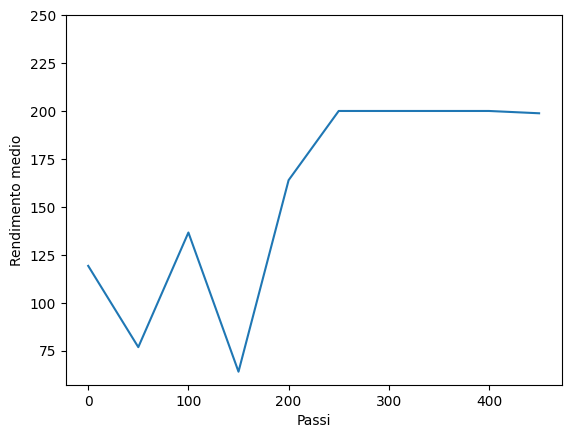

In [ ]:
steps = range(0, num_iterations + 1, eval_interval)
plt.plot(steps, returns)
plt.ylabel('Rendimento medio')
plt.xlabel('Passi')
plt.ylim(top=250)

In [ ]:
def embed_mp4(filename):
  """Integra un file MP4 nel notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [ ]:
num_episodes = 10
video_filename = 'imageio.mp4'
with imageio.get_writer(video_filename, fps=60) as video:
  for _ in range(num_episodes):
    time_step = eval_env.reset()
    video.append_data(eval_py_env.render())
    while not time_step.is_last():
      action_step = tf_agent.policy.action(time_step)
      time_step = eval_env.step(action_step.action)
      video.append_data(eval_py_env.render())

embed_mp4(video_filename)